# Urban Heat Island (UHI) Model Prediction
### Team Leader: Erick Xu
### Team: Erick Xu, Bowen Lu, Kaylee Yoo, Yvonne Mei, Mingzhou Chen

## Load In Dependencies

In [77]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 
from scipy.ndimage import distance_transform_edt

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering and selection
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import statsmodels.formula.api as smf

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

## Response Variable

In [78]:
# Load the training data from csv file and display the first few rows to inspect the data

# NYC
#ground_df = pd.read_csv("./datasets/Training_Data_Hult_NYC.csv")
#ground_df.head()

# Maryland
ground_df = pd.read_csv("./datasets/Training_Data_Maryland.csv")
ground_df.head()

,Longitude,Latitude,UHI Index
0,-77.302700,39.109905,0.993571
1,-77.302690,39.109855,0.994674
2,-77.302677,39.109960,0.993571
3,-77.302655,39.109808,0.994674
4,-77.302630,39.110017,0.993571





### Extracting Band Values from the GeoTIFF Image


In [37]:
def map_satellite_data_multi_revised(sentinel_path, landsat_path, csv_path):
    
    # Read CSV and Initialize
    df_coords = pd.read_csv(csv_path)
    latitudes = df_coords['Latitude'].values
    longitudes = df_coords['Longitude'].values
    results = {}

    # Process Sentinel-2
    if sentinel_path:
        sentinel_data = rxr.open_rasterio(sentinel_path)
        sentinel_crs = sentinel_data.rio.crs
        
        # Get resolution in degrees
        s_resolution_x, s_resolution_y = sentinel_data.rio.resolution()
        s_resolution_x, s_resolution_y = abs(s_resolution_x), abs(s_resolution_y)
        
        # Calculate bbox size for Sentinel-2 (10m resolution)
        s_lon_offset = s_resolution_x * 50  # 50 pixel offset (100x100 box)
        s_lat_offset = s_resolution_y * 50
        
        # Create transformer for Sentinel-2
        proj_wgs84 = Proj(init='epsg:4326')
        proj_sentinel = Proj(sentinel_crs)
        sentinel_transformer = Transformer.from_proj(proj_wgs84, proj_sentinel)
        
        # Initialize arrays for Sentinel-2 bands
        sentinel_bands = {
            'B01': [], 'B02': [], 'B03': [], 'B04': [], 'B05': [],
            'B06': [], 'B07': [], 'B08': [], 'B8A': [], 'B11': [], 'B12': []
        }
        
        # Extract Sentinel-2 values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Processing Sentinel-2"):
            bbox = {
                "x": slice(lon - s_lon_offset, lon + s_lon_offset),
                "y": slice(lat + s_lat_offset, lat - s_lat_offset),
            }
            
            # Map band indices to names
            band_mapping = {
                1: 'B01', 2: 'B02', 3: 'B03', 4: 'B04', 5: 'B05',
                6: 'B06', 7: 'B07', 8: 'B08', 9: 'B8A', 10: 'B11', 11: 'B12'
            }
            
            # Extract values for each band
            for band_idx, band_name in band_mapping.items():
                try:
                    sentinel_bands[band_name].append(np.nanmedian(sentinel_data.sel(band=band_idx, **bbox).values))
                except Exception as e:
                    print(f"Error extracting Sentinel-2 {band_name}: {e}")
                    sentinel_bands[band_name].append(np.nan)
        
        # Add Sentinel bands to results
        for band_name, values in sentinel_bands.items():
            results[f"{band_name}"] = values

    # Process Landsat
    if landsat_path:
        landsat_data = rxr.open_rasterio(landsat_path)
        landsat_crs = landsat_data.rio.crs
        
        # Get resolution in degrees
        l_resolution_x, l_resolution_y = landsat_data.rio.resolution()
        l_resolution_x, l_resolution_y = abs(l_resolution_x), abs(l_resolution_y)
        
        # Calculate bbox size for Landsat (30m resolution)
        # Adjust the box size to 100x100m by using 17 pixels instead of 50
        l_lon_offset = l_resolution_x * 17  
        l_lat_offset = l_resolution_y * 17
        
        # Create transformer for Landsat
        proj_landsat = Proj(landsat_crs)
        landsat_transformer = Transformer.from_proj(proj_wgs84, proj_landsat)
        
        # Initialize arrays for Landsat B11 (LST) band
        lst_values = []
        
        # Extract Landsat LST values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Processing Landsat LST"):
            bbox = {
                "x": slice(lon - l_lon_offset, lon + l_lon_offset),
                "y": slice(lat + l_lat_offset, lat - l_lat_offset),
            }
            
            try:
                # For single band, check if we need to specify band parameter
                if landsat_data.rio.count > 1:
                    # If multi-band for some reason, get the first band
                    lst_values.append(np.nanmedian(landsat_data.sel(band=1, **bbox).values))
                else:
                    # If single band, we don't specify band
                    lst_values.append(np.nanmedian(landsat_data.sel(**bbox).values))
            except Exception as e:
                print(f"Error extracting Landsat LST: {e}")
                lst_values.append(np.nan)
        
        # Add Landsat LST to results
        results["BT11"] = lst_values


    # Create Final DataFrame
    final_df = pd.DataFrame(results)
    final_df['Latitude'] = latitudes
    final_df['Longitude'] = longitudes

    return final_df

In [79]:
# defining paths for tiff files

# NYC
#sentinel_path = "./tiffs/NY_S2_full_channel_complete_2mo.tiff"
#landsat_path  = "./tiffs/Landsat_NY.tiff"
#csv_path      = "./datasets/Training_Data_NYC.csv"

# Maryland
sentinel_path = "./tiffs/Myrland_S2_full_channel_complete_2mo.tiff"             
landsat_path  = "./tiffs/Landsat_Maryland.tiff"
csv_path      = "./datasets/Training_Data_Maryland.csv"

In [39]:
# Mapping satellite data with training data.
final_data = map_satellite_data_multi_revised(sentinel_path, landsat_path, csv_path)

Processing Landsat LST: 100%|██████████| 34502/34502 [00:07<00:00, 4841.73it/s]


In [41]:
final_data.head(n=5)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,BT11,Latitude,Longitude
0,1310.0,1327.0,1566.0,1347.0,1900.0,3828.0,4602.0,4748.0,4900.0,4915.0,2971.0,38.872464,39.109905,-77.302700
1,1310.0,1327.0,1566.0,1347.0,1900.0,3828.0,4602.0,4748.0,4900.0,4915.0,2971.0,38.872464,39.109855,-77.302690
2,1311.0,1328.0,1570.0,1348.0,1904.0,3829.0,4602.0,4748.0,4900.0,4916.0,2975.0,38.872464,39.109960,-77.302677
3,1310.0,1326.0,1566.0,1346.0,1899.0,3832.0,4606.0,4752.0,4900.0,4917.0,2971.0,38.872464,39.109808,-77.302655
4,1312.0,1330.0,1571.0,1349.5,1906.0,3831.0,4604.0,4748.0,4900.0,4917.0,2978.0,38.872464,39.110017,-77.302630


## Feature Engineering

In [42]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

# CAlculate Green NDVI
final_data["GNDVI"] = (final_data["B08"] - final_data["B03"]) / (final_data["B08"] + final_data["B03"])
final_data['GNDVI'] = final_data['GNDVI'].replace([np.inf, -np.inf], np.nan) 

# Calculate Red Edge NDVI
final_data["RENDVI"] = (final_data["B08"] - final_data["B05"]) / (final_data["B08"] + final_data["B05"])
final_data['RENDVI'] = final_data['RENDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate SWIR-based Index (NDBI - Normalized Difference Built-up Index)
final_data["NDBI"] = (final_data["B11"] - final_data["B08"]) / (final_data["B11"] + final_data["B08"])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate Normalized Difference Water Index
final_data["NDWI"] = (final_data["B03"] - final_data["B11"]) / (final_data["B03"] + final_data["B11"])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)

# Calculate Moisture Stress Index
final_data["MSI"] = (final_data["B11"] / final_data["B08"])
final_data['MSI'] = final_data['MSI'].replace([np.inf, -np.inf], np.nan)

# Calculate Built-up Index
final_data["BU"] = final_data["NDBI"] - final_data["NDVI"]

# Calculate NDMI (Normalized Difference Moisture Index)
final_data['NDMI'] = (final_data['B08'] - final_data['B11']) / (final_data['B08'] + final_data['B11'])
final_data['NDMI'] = final_data['NDMI'].replace([np.inf, -np.inf], np.nan)

# Calculate Bare Soil Index
final_data["BSI"] = ((final_data["B11"] + final_data["B04"]) - (final_data["B08"] + final_data["B02"])) / ((final_data["B11"] + final_data["B04"]) + (final_data["B08"] + final_data["B02"]))
final_data['BSI'] = final_data['BSI'].replace([np.inf, -np.inf], np.nan)

# Calculate Thermal Reflectance Proxy
final_data["TRP"] = (final_data["B08"] + final_data["B11"] + final_data["B12"]) / 3

# Calculate Surface Absorption Index
final_data["SAI"] = final_data["B11"] / (final_data["B12"] + final_data["B11"])
final_data['SAI'] = final_data['SAI'].replace([np.inf, -np.inf], np.nan)

# Calculate Red Edge Maximum Ratio
final_data["REMR"] = final_data[["B05", "B06", "B07", "B8A"]].max(axis=1) / (final_data["B05"] + final_data["B06"] + final_data["B07"] + final_data["B8A"])
final_data['REMR'] = final_data['REMR'].replace([np.inf, -np.inf], np.nan)

# Calculate Urban Heat Contrast Index
final_data["UHCI"] = (final_data["B01"] + final_data["B11"] + final_data["B12"]) / (final_data["B03"] + final_data["B08"])

# Calculate Urban Reflectivity Loss
final_data["URL"] = (final_data["B01"] + final_data["B02"] + final_data["B03"]) / (final_data["B08"] + final_data["B11"] + final_data["B12"])



In [43]:
# 1. Water mask using NDWI
water_mask = final_data['NDWI'] > 0.3  # Threshold for water bodies
final_data['water_mask'] = water_mask.astype(int)

# 2. Vegetation mask using NDVI
vegetation_mask = final_data['NDVI'] > 0.4  # Threshold for vegetation 
final_data['vegetation_mask'] = vegetation_mask.astype(int)

# 3. Built-up area mask using NDBI
built_up_mask = final_data['NDBI'] > 0.1  # Threshold for built-up areas
final_data['built_up_mask'] = built_up_mask.astype(int)

# 4. Bare soil mask using BSI
bare_soil_mask = (final_data['BSI'] > 0.2) & (final_data['NDVI'] < 0.2)
final_data['bare_soil_mask'] = bare_soil_mask.astype(int)

# 5. Dense urban areas (high NDBI AND low NDVI)
dense_urban_mask = (final_data['NDBI'] > 0.2) & (final_data['NDVI'] < 0.1)
final_data['dense_urban_mask'] = dense_urban_mask.astype(int)

# 6. Green urban areas (moderate NDBI AND moderate NDVI)
green_urban_mask = (final_data['NDBI'] > 0) & (final_data['NDVI'] > 0.3)
final_data['green_urban_mask'] = green_urban_mask.astype(int)

# 7. Industrial/commercial areas (high NDBI AND high BSI)
industrial_mask = (final_data['NDBI'] > 0.15) & (final_data['BSI'] > 0.1)
final_data['industrial_mask'] = industrial_mask.astype(int)

In [44]:
def mask_distance(mask):
    """Calculate the distance to the nearest 1 in the mask using distance transform."""

    mask_inv = 1 - mask  # Invert the mask to compute distance to nearest 1 in original mask
    distances = distance_transform_edt(mask_inv)
    return distances

# Distance to water
distance_to_water = mask_distance(water_mask)

# Distance to vegetation
distance_to_vegetation = mask_distance(vegetation_mask)

# Distance to built-up areas
distance_to_built = mask_distance(built_up_mask)

# Distance to dense urban areas
distance_to_dense_urban = mask_distance(dense_urban_mask)

# Distance to green urban areas
distance_to_green_urban = mask_distance(green_urban_mask)

# Distance to industrial/commercial areas
distance_to_industrial = mask_distance(industrial_mask)

# Convert distances to meters based on resolution
# For Sentinel-2: 10m resolution for most bands
pixel_resolution = 10  # meters
final_data['dist_water'] = distance_to_water * 10
final_data['dist_vegetation'] = distance_to_vegetation * 10
final_data['dist_built'] = distance_to_built * 10
final_data['dist_dense_urban'] = distance_to_dense_urban * 10
final_data['dist_green_urban'] = distance_to_green_urban * 10
final_data['dist_industrial'] = distance_to_industrial * 10



# Calculate Inverse Green-Urban Contrast
final_data["IGUC"] = (final_data["B01"] + final_data["B04"] + final_data["B05"]) / (final_data["B03"] + final_data["dist_green_urban"])

# Calculate Composite Urban Intensity Score
final_data["CUIS"] = (final_data["B01"] + final_data["B11"] + final_data["dist_built"] + final_data["dist_dense_urban"]) / 4

# Calculate Green Space Deficit
final_data["GSD"] = 1 / (final_data["NDVI"] + final_data["GNDVI"] + final_data["RENDVI"] + 0.01)

# Calculate SWIR Heat Index
final_data["SHI"] = (final_data["B11"] + final_data["B12"])

# Calculate Urban Vegetation Contrast Ratio
final_data["UVCR"] = final_data["B01"] / final_data["B08"]

# Approximate Albedo using visible and NIR bands
final_data['Albedo'] = (final_data['B02'] + final_data['B03'] + final_data['B04'] + final_data['B08']) / 4.0
final_data['Albedo'] = final_data['Albedo'].replace([np.inf, -np.inf], np.nan)

# Calculate MNDWI (Modified Normalized Difference Water Index) using B03 and B11
final_data['MNDWI'] = (final_data['B03'] - final_data['B11']) / (final_data['B03'] + final_data['B11'])
final_data['MNDWI'] = final_data['MNDWI'].replace([np.inf, -np.inf], np.nan)

# Calculate ISI (Impervious Surface Index) using B11 and B04
final_data['ISI'] = (final_data['B11'] + final_data['B04']) / (final_data['B08'] + final_data['B02'])
final_data['ISI'] = final_data['ISI'].replace([np.inf, -np.inf], np.nan)

# Calculate Normalized Difference Ice/Snow Index
final_data["NDISI"] = (final_data["B11"] - (final_data["B04"] + final_data["B08"])) / (final_data["B11"] + (final_data["B04"] + final_data["B08"]))

# Calculate Enhanced Vegetation Index
final_data["EVI"] = 2.5 * (final_data["B08"] - final_data["B04"]) / (final_data["B08"] + 6 * final_data["B04"] - 7.5 * final_data["B02"] + 1)

# Joining Datasets

In [45]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [46]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data["UHI_Index"] = uhi_data["UHI Index"]
uhi_data.drop(columns=["UHI Index"], inplace=True)
uhi_data.head()

,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,...,CUIS,GSD,SHI,UVCR,Albedo,MNDWI,ISI,NDISI,EVI,UHI_Index
0,-77.302700,39.109905,1310.0,1327.0,1566.0,1347.0,1900.0,3828.0,4602.0,4748.0,...,1561.25,0.666508,7886.0,0.275906,2247.000,-0.516741,1.030782,-0.107175,2.953795,0.993571
1,-77.302690,39.109855,1310.0,1327.0,1566.0,1347.0,1900.0,3828.0,4602.0,4748.0,...,1566.25,0.666508,7886.0,0.275906,2247.000,-0.516741,1.030782,-0.107175,2.953795,0.994674
2,-77.302677,39.109960,1311.0,1328.0,1570.0,1348.0,1904.0,3829.0,4602.0,4748.0,...,1571.75,0.667427,7891.0,0.276116,2248.500,-0.515880,1.030941,-0.107156,2.954466,0.993571
3,-77.302655,39.109808,1310.0,1326.0,1566.0,1346.0,1899.0,3832.0,4606.0,4752.0,...,1576.75,0.665879,7888.0,0.275673,2247.500,-0.516890,1.030438,-0.107217,2.952497,0.994674
4,-77.302630,39.110017,1312.0,1330.0,1571.0,1349.5,1906.0,3831.0,4604.0,4748.0,...,1582.25,0.667895,7895.0,0.276327,2249.625,-0.515721,1.031013,-0.107177,2.959335,0.993571


### Removing Unnecessary Rows

In [47]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A",
                    "B11", "B12", "BT11"]

for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head(n = 5)


,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,...,CUIS,GSD,SHI,UVCR,Albedo,MNDWI,ISI,NDISI,EVI,UHI_Index
0,-77.302700,39.109905,1310.0,1327.0,1566.0,1347.0,1900.0,3828.0,4602.0,4748.0,...,1561.25,0.666508,7886.0,0.275906,2247.000,-0.516741,1.030782,-0.107175,2.953795,0.993571
2,-77.302677,39.109960,1311.0,1328.0,1570.0,1348.0,1904.0,3829.0,4602.0,4748.0,...,1571.75,0.667427,7891.0,0.276116,2248.500,-0.515880,1.030941,-0.107156,2.954466,0.993571
3,-77.302655,39.109808,1310.0,1326.0,1566.0,1346.0,1899.0,3832.0,4606.0,4752.0,...,1576.75,0.665879,7888.0,0.275673,2247.500,-0.516890,1.030438,-0.107217,2.952497,0.994674
4,-77.302630,39.110017,1312.0,1330.0,1571.0,1349.5,1906.0,3831.0,4604.0,4748.0,...,1582.25,0.667895,7895.0,0.276327,2249.625,-0.515721,1.031013,-0.107177,2.959335,0.993571
6,-77.302575,39.110082,1312.0,1330.0,1572.0,1350.0,1907.0,3832.0,4605.0,4748.0,...,1592.25,0.668154,7896.0,0.276327,2250.000,-0.515488,1.031096,-0.107217,2.955811,0.993571


In [48]:
# Drop Lat/Lon — not allowed as features
uhi_data = uhi_data.drop(columns=['Latitude', 'Longitude'])

# Drop missing values (from NDVI or TIFF bands)
uhi_data = uhi_data.dropna().reset_index(drop=True)

# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

# Preview cleaned dataset
uhi_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,CUIS,GSD,SHI,UVCR,Albedo,MNDWI,ISI,NDISI,EVI,UHI_Index
0,1310.0,1327.0,1566.0,1347.0,1900.0,3828.0,4602.0,4748.0,4900.0,4915.0,...,1561.25,0.666508,7886.0,0.275906,2247.000,-0.516741,1.030782,-0.107175,2.953795,0.993571
1,1311.0,1328.0,1570.0,1348.0,1904.0,3829.0,4602.0,4748.0,4900.0,4916.0,...,1571.75,0.667427,7891.0,0.276116,2248.500,-0.515880,1.030941,-0.107156,2.954466,0.993571
2,1310.0,1326.0,1566.0,1346.0,1899.0,3832.0,4606.0,4752.0,4900.0,4917.0,...,1576.75,0.665879,7888.0,0.275673,2247.500,-0.516890,1.030438,-0.107217,2.952497,0.994674
3,1312.0,1330.0,1571.0,1349.5,1906.0,3831.0,4604.0,4748.0,4900.0,4917.0,...,1582.25,0.667895,7895.0,0.276327,2249.625,-0.515721,1.031013,-0.107177,2.959335,0.993571
4,1312.0,1330.0,1572.0,1350.0,1907.0,3832.0,4605.0,4748.0,4900.0,4917.0,...,1592.25,0.668154,7896.0,0.276327,2250.000,-0.515488,1.031096,-0.107217,2.955811,0.993571


## Model Building

In [49]:
# All features
uhi_data = uhi_data[["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A",
                    "B11", "B12", "BT11", "NDVI", "GNDVI", "RENDVI", "NDBI", "NDWI",
                    "MSI", "BU", "NDMI", "BSI", "TRP", "SAI", "REMR",
                    "UHCI", "URL",
                    "dist_water", "dist_vegetation", "dist_built",
                    "dist_dense_urban", "dist_green_urban",
                    "dist_industrial", "IGUC", "CUIS", "GSD", "SHI",
                    "UVCR", "Albedo", "MNDWI", "ISI", "NDISI", "EVI", 
                     "UHI_Index"]]

In [51]:
# Significant p-values
uhi_data = uhi_data[["B05", "B07", "B8A", "BT11", "NDVI", "GNDVI", "RENDVI", "NDBI", "NDWI",
                    "MSI", "BU", "NDMI", "BSI", "dist_vegetation", "dist_green_urban",
                    "IGUC", "UVCR", "MNDWI", "ISI", "NDISI", "EVI", 
                     "UHI_Index"]]

In [ ]:
# best R-squared score
uhi_data = uhi_data[["B01", "B03", "B05", "B06", "B07", "B8A",
                     "B12", "BT11", "NDISI", "EVI",
                    "dist_water", "dist_built",
                    "dist_dense_urban", "dist_green_urban", "dist_industrial", "UHI_Index"]]

In [52]:
uhi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31763 entries, 0 to 31762
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   B05               31763 non-null  float64
 1   B07               31763 non-null  float64
 2   B8A               31763 non-null  float64
 3   BT11              31763 non-null  float64
 4   NDVI              31763 non-null  float64
 5   GNDVI             31763 non-null  float64
 6   RENDVI            31763 non-null  float64
 7   NDBI              31763 non-null  float64
 8   NDWI              31763 non-null  float64
 9   MSI               31763 non-null  float64
 10  BU                31763 non-null  float64
 11  NDMI              31763 non-null  float64
 12  BSI               31763 non-null  float64
 13  dist_vegetation   31763 non-null  float64
 14  dist_green_urban  31763 non-null  float64
 15  IGUC              31763 non-null  float64
 16  UVCR              31763 non-null  float6

### Correlation and Linear Regression

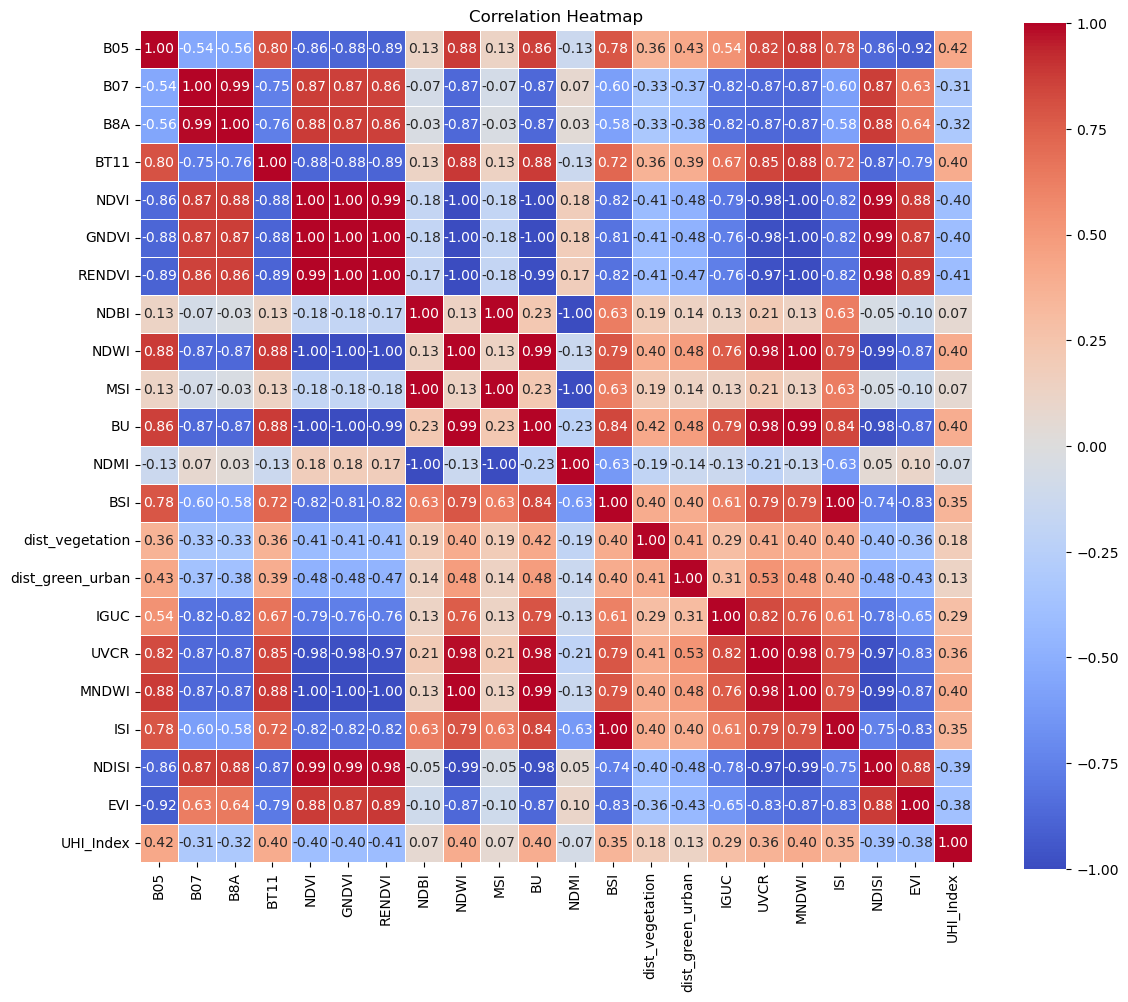

In [53]:
# Correlation heatmap
corr_matrix = uhi_data.corr(numeric_only=True)

# Set the figure size
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

# Set the title and adjust layout
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

This correlation heatmap shows how different features are related to each other and to the UHI Index. Blue colors mean a strong negative relationship, while red means a strong positive one. We can see that areas with more vegetation (like high NDVI and EVI values) usually have lower UHI Index, which means plants help cool the city. On the other hand, features related to buildings and built-up land (like NDBI and BU) are linked to higher UHI values, showing that more construction makes cities hotter. This chart helps us understand which features are most important for predicting urban heat and supports the choices we made in building our model

In [50]:
# Linear Regression Model
# Step 1: INSTANTIATE a model object
lm_best = smf.ols(formula = """UHI_Index ~ B01 + B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A +
                    B11 + B12 + BT11 + NDVI + GNDVI + RENDVI + NDBI + NDWI +
                    MSI + BU + NDMI + BSI + TRP + SAI + REMR +
                    UHCI + URL +
                    dist_water + dist_vegetation + dist_built +
                    dist_dense_urban + dist_green_urban +
                    dist_industrial + IGUC + CUIS + GSD + SHI +
                    UVCR + Albedo + MNDWI + ISI + NDISI + EVI""",
                  data = uhi_data)


# Step 2: FIT the data into the model object
results = lm_best.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              UHI_Index   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.818
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           1.40e-23
Time:                        21:21:44   Log-Likelihood:                 83990.
No. Observations:               31763   AIC:                        -1.679e+05
Df Residuals:                   31730   BIC:                        -1.676e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.4435      2.599  

### Train and Test Split 

In [54]:
# Simplified preprocessing (no scaling)
X = uhi_data.drop(columns=["UHI_Index"])
y = uhi_data["UHI_Index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### Feature Scaling 

In [55]:
# Yeo-Johnson Transformation
#yeo = PowerTransformer(method='yeo-johnson')
#X_train = yeo.fit_transform(X_train)
#X_test = yeo.transform(X_test)

# StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

In [56]:
# Model using Random Forest Regressor
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

### Model Evaluation

In [57]:
# Evaluate
train_r2 = best_model.score(X_train, y_train)
test_r2 = best_model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")

# Gap between train and test R²
gap = train_r2 - test_r2
print(f"Gap: {gap:.3f}")

Train R²: 0.982, Test R²: 0.875
Gap: 0.107


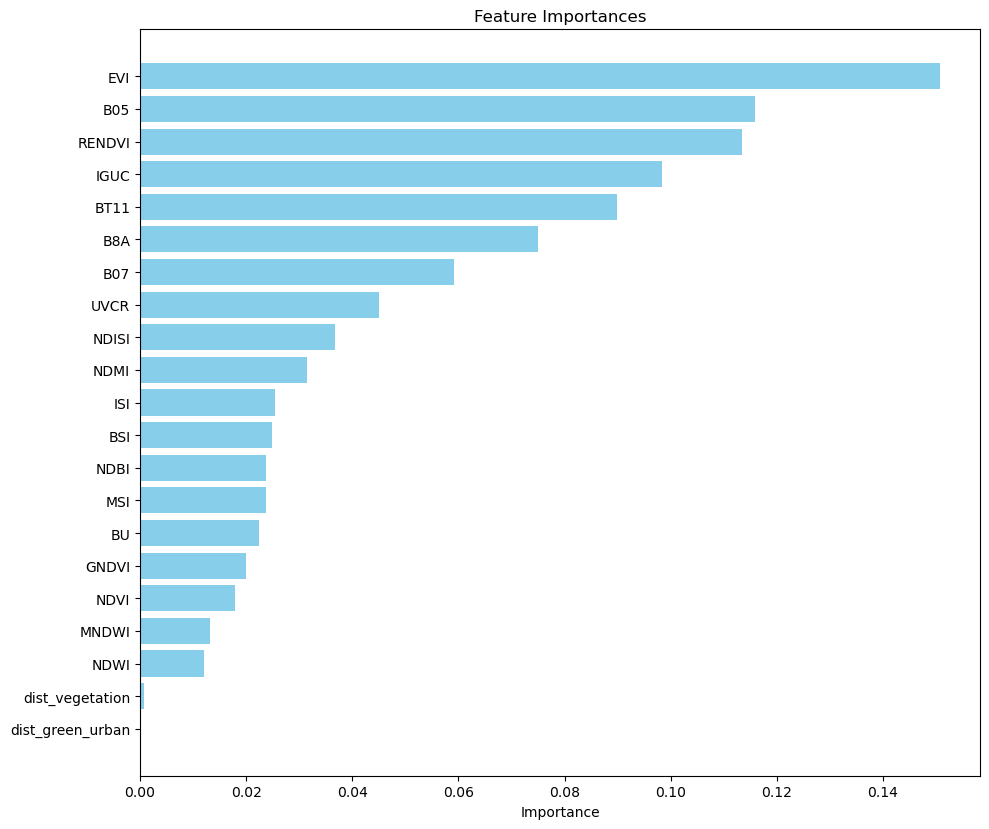

In [71]:
# feature importances
importances = best_model.feature_importances_
features = uhi_data.drop(columns=['UHI_Index']).columns
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10, len(features) * 0.4))  # Dynamically adjust height
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()

The bar chart above displays the importance of each feature in our predictive model for urban heat. EVI (Enhanced Vegetation Index) and B05 (Vegetation classification red edge) stand out as the most influential factors, followed closely by other vegetation and spectral indices such as RENDVI and IGUC. Features like NDVI, NDBI, and distance-based variables contributed less in this particular model, indicating that not all expected predictors had equal impact. Understanding these rankings helps us refine our feature selection and better interpret what drives heat patterns in urban environments.

## Submission

In [81]:
#Reading the coordinates for the submission

# NYC
#sub_path = "Submission_NYC.csv"
#test_file = pd.read_csv(sub_path)
#test_file.head()

# Maryland
sub_path = "Submission_Maryland.csv"
test_file = pd.read_csv(sub_path)
test_file.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,NaN
1,-77.300382,39.113362,NaN
2,-77.300285,39.108433,NaN
3,-77.299315,39.107880,NaN
4,-77.299300,39.115225,NaN


In [60]:
# Mapping 10m satellite data with training data.
val_data = map_satellite_data_multi_revised(sentinel_path, landsat_path, sub_path)

Processing Landsat LST: 100%|██████████| 3834/3834 [00:01<00:00, 3528.63it/s]


In [61]:
val_data.head(n = 5)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,BT11,Latitude,Longitude
0,1308.0,1328.0,1575.0,1351.0,1907.0,3845.0,4622.0,4764.0,4905.0,4917.0,2993.0,38.687891,39.109247,-77.301697
1,1319.0,1330.0,1583.0,1339.0,1925.0,3735.0,4468.0,4576.0,4772.0,4765.0,2980.0,38.510154,39.113362,-77.300382
2,1306.0,1328.0,1598.0,1356.5,1937.0,3877.0,4694.5,4804.0,4973.0,4967.0,3057.0,36.818234,39.108433,-77.300285
3,1306.0,1332.0,1619.0,1367.0,1970.0,3900.0,4732.0,4840.0,5020.0,5007.5,3097.0,36.804562,39.107880,-77.299315
4,1326.0,1336.0,1572.0,1339.0,1917.0,3678.0,4396.0,4488.0,4704.0,4692.0,2963.0,40.608818,39.115225,-77.299300


In [64]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

# CAlculate Green NDVI
val_data["GNDVI"] = (val_data["B08"] - val_data["B03"]) / (val_data["B08"] + val_data["B03"])
val_data['GNDVI'] = val_data['GNDVI'].replace([np.inf, -np.inf], np.nan) 

# Calculate Red Edge NDVI
val_data["RENDVI"] = (val_data["B08"] - val_data["B05"]) / (val_data["B08"] + val_data["B05"])
val_data['RENDVI'] = val_data['RENDVI'].replace([np.inf, -np.inf], np.nan)

# Calculate SWIR-based Index (NDBI - Normalized Difference Built-up Index)
val_data["NDBI"] = (val_data["B11"] - val_data["B08"]) / (val_data["B11"] + val_data["B08"])
val_data['NDBI'] = val_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Calculate Normalized Difference Water Index
val_data["NDWI"] = (val_data["B03"] - val_data["B11"]) / (val_data["B03"] + val_data["B11"])
val_data['NDWI'] = val_data['NDWI'].replace([np.inf, -np.inf], np.nan)

# Calculate Moisture Stress Index
val_data["MSI"] = (val_data["B11"] / val_data["B08"])
val_data['MSI'] = val_data['MSI'].replace([np.inf, -np.inf], np.nan)

# Calculate Built-up Index
val_data["BU"] = val_data["NDBI"] - val_data["NDVI"]

# Calculate Bare Soil Index
val_data["BSI"] = ((val_data["B11"] + val_data["B04"]) - (val_data["B08"] + val_data["B02"])) / ((val_data["B11"] + val_data["B04"]) + (val_data["B08"] + val_data["B02"]))
val_data['BSI'] = val_data['BSI'].replace([np.inf, -np.inf], np.nan)

# Calculate Thermal Reflectance Proxy
val_data["TRP"] = (val_data["B08"] + val_data["B11"] + val_data["B12"]) / 3

# Calculate Surface Absorption Index
val_data["SAI"] = val_data["B11"] / (val_data["B12"] + val_data["B11"])
val_data['SAI'] = val_data['SAI'].replace([np.inf, -np.inf], np.nan)

# Calculate Red Edge Maximum Ratio
val_data["REMR"] = val_data[["B05", "B06", "B07", "B8A"]].max(axis=1) / (val_data["B05"] + val_data["B06"] + val_data["B07"] + val_data["B8A"])
val_data['REMR'] = val_data['REMR'].replace([np.inf, -np.inf], np.nan)

# Calculate Urban Heat Contrast Index
val_data["UHCI"] = (val_data["B01"] + val_data["B11"] + val_data["B12"]) / (val_data["B03"] + val_data["B08"])

# Calculate Urban Reflectivity Loss
val_data["URL"] = (val_data["B01"] + val_data["B02"] + val_data["B03"]) / (val_data["B08"] + val_data["B11"] + val_data["B12"])



In [65]:
# 1. Water mask using NDWI
water_mask = val_data['NDWI'] > 0.3  # Threshold for water bodies
val_data['water_mask'] = water_mask.astype(int)

# 2. Vegetation mask using NDVI
vegetation_mask = val_data['NDVI'] > 0.4  # Threshold for vegetation 
val_data['vegetation_mask'] = vegetation_mask.astype(int)

# 3. Built-up area mask using NDBI
built_up_mask = val_data['NDBI'] > 0.1  # Threshold for built-up areas
val_data['built_up_mask'] = built_up_mask.astype(int)

# 4. Bare soil mask using BSI
bare_soil_mask = (val_data['BSI'] > 0.2) & (val_data['NDVI'] < 0.2)
val_data['bare_soil_mask'] = bare_soil_mask.astype(int)

# 5. Dense urban areas (high NDBI AND low NDVI)
dense_urban_mask = (val_data['NDBI'] > 0.2) & (val_data['NDVI'] < 0.1)
val_data['dense_urban_mask'] = dense_urban_mask.astype(int)

# 6. Green urban areas (moderate NDBI AND moderate NDVI)
green_urban_mask = (val_data['NDBI'] > 0) & (val_data['NDVI'] > 0.3)
val_data['green_urban_mask'] = green_urban_mask.astype(int)

# 7. Industrial/commercial areas (high NDBI AND high BSI)
industrial_mask = (val_data['NDBI'] > 0.15) & (val_data['BSI'] > 0.1)
val_data['industrial_mask'] = industrial_mask.astype(int)

In [67]:
# Distance to water
distance_to_water = mask_distance(water_mask)

# Distance to vegetation
distance_to_vegetation = mask_distance(vegetation_mask)

# Distance to built-up areas
distance_to_built = mask_distance(built_up_mask)

# Distance to dense urban areas
distance_to_dense_urban = mask_distance(dense_urban_mask)

# Distance to green urban areas
distance_to_green_urban = mask_distance(green_urban_mask)

# Distance to industrial/commercial areas
distance_to_industrial = mask_distance(industrial_mask)

# Convert distances to meters based on resolution
# For Sentinel-2: 10m resolution for most bands
pixel_resolution = 10  # meters
val_data['dist_water'] = distance_to_water * 10
val_data['dist_vegetation'] = distance_to_vegetation * 10
val_data['dist_built'] = distance_to_built * 10
val_data['dist_dense_urban'] = distance_to_dense_urban * 10
val_data['dist_green_urban'] = distance_to_green_urban * 10
val_data['dist_industrial'] = distance_to_industrial * 10


# Calculate Inverse Green-Urban Contrast
val_data["IGUC"] = (val_data["B01"] + val_data["B04"] + val_data["B05"]) / (val_data["B03"] + val_data["dist_green_urban"])

# Calculate Composite Urban Intensity Score
val_data["CUIS"] = (val_data["B01"] + val_data["B11"] + val_data["dist_built"] + val_data["dist_dense_urban"]) / 4

# Calculate Green Space Deficit
val_data["GSD"] = 1 / (val_data["NDVI"] + val_data["GNDVI"] + val_data["RENDVI"] + 0.01)

# Calculate SWIR Heat Index
val_data["SHI"] = (val_data["B11"] + val_data["B12"])

# Calculate Urban Vegetation Contrast Ratio
val_data["UVCR"] = val_data["B01"] / val_data["B08"]

# Approximate Albedo using visible and NIR bands
val_data['Albedo'] = (val_data['B02'] + val_data['B03'] + val_data['B04'] + val_data['B08']) / 4.0
val_data['Albedo'] = val_data['Albedo'].replace([np.inf, -np.inf], np.nan)

# Calculate MNDWI (Modified Normalized Difference Water Index) using B03 and B11
val_data['MNDWI'] = (val_data['B03'] - val_data['B11']) / (val_data['B03'] + val_data['B11'])
val_data['MNDWI'] = val_data['MNDWI'].replace([np.inf, -np.inf], np.nan)

# Calculate ISI (Impervious Surface Index) using B11 and B04
val_data['ISI'] = (val_data['B11'] + val_data['B04']) / (val_data['B08'] + val_data['B02'])
val_data['ISI'] = val_data['ISI'].replace([np.inf, -np.inf], np.nan)

# Calculate NDMI (Normalized Difference Moisture Index)
val_data['NDMI'] = (val_data['B08'] - val_data['B11']) / (val_data['B08'] + val_data['B11'])
val_data['NDMI'] = val_data['NDMI'].replace([np.inf, -np.inf], np.nan)

# Calculate Normalized Difference Ice/Snow Index
val_data["NDISI"] = (val_data["B11"] - (val_data["B04"] + val_data["B08"])) / (val_data["B11"] + (val_data["B04"] + val_data["B08"]))
val_data['NDISI'] = val_data['NDISI'].replace([np.inf, -np.inf], np.nan)

# Calculate Enhanced Vegetation Index
val_data["EVI"] = 2.5 * (val_data["B08"] - val_data["B04"]) / (val_data["B08"] + 6 * val_data["B04"] - 7.5 * val_data["B02"] + 1)
val_data['EVI'] = val_data['EVI'].replace([np.inf, -np.inf], np.nan)

In [68]:
# Drop any missing values
val_data = val_data.dropna().reset_index(drop=True)
val_data.head(n = 5)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,CUIS,GSD,SHI,UVCR,Albedo,MNDWI,ISI,NDMI,NDISI,EVI
0,1308.0,1328.0,1575.0,1351.0,1907.0,3845.0,4622.0,4764.0,4905.0,4917.0,...,1561.250,0.666896,7910.0,0.274559,2254.500,-0.514787,1.028890,-0.015804,-0.108593,2.931123
1,1319.0,1330.0,1583.0,1339.0,1925.0,3735.0,4468.0,4576.0,4772.0,4765.0,...,1531.000,0.689184,7745.0,0.288243,2207.000,-0.501260,1.033525,-0.020233,-0.107678,3.069992
2,1306.0,1328.0,1598.0,1356.5,1937.0,3877.0,4694.5,4804.0,4973.0,4967.0,...,1583.250,0.668582,8024.0,0.271857,2271.625,-0.513176,1.031230,-0.016682,-0.107257,2.888321
3,1306.0,1332.0,1619.0,1367.0,1970.0,3900.0,4732.0,4840.0,5020.0,5007.5,...,1598.375,0.671297,8104.5,0.269835,2289.500,-0.511356,1.032809,-0.017009,-0.106960,2.843924
4,1326.0,1336.0,1572.0,1339.0,1917.0,3678.0,4396.0,4488.0,4704.0,4692.0,...,1529.500,0.697833,7655.0,0.295455,2183.750,-0.498084,1.035543,-0.022222,-0.107900,3.145226


In [69]:
# Significant p-value features
submission_val_data = val_data[["B05", "B07", "B8A", "BT11", "NDVI", "GNDVI", "RENDVI", "NDBI", "NDWI",
                    "MSI", "BU", "NDMI", "BSI", "dist_vegetation", "dist_green_urban",
                    "IGUC", "UVCR", "MNDWI", "ISI", "NDISI", "EVI"]]

# Scale features using the same scaler from training
submission_scaled = sc.transform(submission_val_data.values)

# Make predictions using best model
final_predictions = best_model.predict(submission_scaled)

# Build final submission DataFrame
submission_df = pd.DataFrame({
    'Longitude': test_file['Longitude'],
    'Latitude': test_file['Latitude'],
    'UHI Index': final_predictions
})

In [ ]:
# Save predictions to CSV

# NYC
#submission_df.to_csv("Predicted_Data_NYC.csv", index=False)

# Maryland
submission_df.to_csv("Predicted_Data_Maryland.csv", index=False)

# Preview the output
submission_df.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,0.991526
1,-77.300382,39.113362,0.982450
2,-77.300285,39.108433,0.994944
3,-77.299315,39.107880,0.989585
4,-77.299300,39.115225,0.978304


### Introduction to the challenge

 Urban Heat Islands(UHIs) pose serious challenges to city living, driving up energy use, worsening air quality, and amplifying health risks. Our objective was to predict UHI intensity in urban regions using a combination of Sentinel-2 and Landsat satellite imagery, advanced feature engineering, and machine learning. For our analysis, we extracted and processed multispectral band data, engineered dozens of domain-specific indices (like NDVI, NDBI, NDWI, and more), and constructed a model using RandomForestRegressor. The project required careful geospatial alignment, handling of high-dimensional data, and interpretability of model results. Ultimately, our team hopes this project could provide actionable insights for urban planners and policymakers to guide heat mitigation strategies and sustainable urban design. Our model is tunned based on Maryland data with the goal of achieving a model that can be generally good for any other city, such as New York.

### Top Three Actionable Recommendations

Recommendation 1: Prioritize Greening in Hotspots

The correlation and final model results show that vegetation, especially the health of the vegetation, is essential to keep a balanced temperature. Vegetation can help cool the environment around them. However, the model suggests that it's not just about the quantity but the quality. The vegetation must be well maintained so it's in good health. Increasing urban greenery (parks, green roofs, street trees) in the city and maintaining the vegetation in good health will most effectively reduce temperatures and improve residents’ quality of life.

Recommendation 2: Retrofit Built-Up Districts with Cooling Materials

Our research can help us prioritize which areas within a city should be remodeled first. This means prioritizing applying heat-reducing materials and technologies such as cool roofs, cool pavements, shades, and green roofs in areas with high UHI indices. By focusing on these high-risk, high-density districts, cities can directly reduce surface temperatures, improve resident comfort, and build greater resilience against future heat events. Our model can be practically applied to policies because it provides spatially accurate indications of “where is the most effective target”.

Recommendation 3: Use Spatial Distance Metrics in Policy

Distance-based spatial features, like proximity to water bodies, vegetation, or dense urban/industrial zones, were found to be significant predictors in our model, especially for vegetation and green urban. As mentioned earlier, the UHI index is relatively low near Central Park in New York, and also lower near the Hudson River than in mid-Manhattan. Urban zoning and new development should factor in optimal distances to green and blue spaces. Planning neighborhoods and facilities to maximize access to parks and water can minimize exposure to heat and support public health.

### Analysis

Our analysis starts with extracting band values from the GeoTIFF images. We extracted spectral band values from Sentinel-2 and Landsat images for each study location and engineered a diverse set of features. These included classic indices like NDVI, NDBI, NDWI, and MSI to capture vegetation, water, and urbanization effects, as well as advanced composite indices such as BU and CUIS to reflect complex urban heat dynamics. We used the values of different satellite indices to decide the type of land point, for example, whether each location was water, plants, buildings, factories, or bare ground. Also, to provide spatial context, we calculated the distance from each observation to the nearest water body, green space, dense urban area, and other land covers, converting these to meters. The best features were selected based on their p-values from the linear regression. Only features with p-values less than 0.05 were selected to be used in the final model.

To train our final model, we performed a 75/25 train-test split and standardized all features using a StandardScaler. We used a Random Forest Regressor with 200 estimators, achieving high performance (Train R²: 0.982, Test R²: 0.875 for Maryland). Random Forest is used because it handles complex, non-linear relationships well and doesn’t require much data preprocessing. It’s less likely to overfit than a single decision tree because it combines many trees and averages their predictions. It also gives clear feature importance scores, helping you understand which variables matter most. The feature importance scores from the trained model are collected to represent how much each feature contributes to reducing error when making predictions.

Feature importance analysis revealed that EVI is the most important feature. The EVI quantifies the vegetation's health and greenness. The more green and healthy the plants are, the better the plants can help cool the temperature around them. The other two most important features are the B05 (Vegetation classification red edge) and RENDVI. These are also used to indicate the health of vegetation. As seen in the correlation heatmap, vegetation helps cool while build-ups are generally warmer. This suggests that the health of the vegetation could determine its ability to cool the environment around it, and so in a large area, such as a city, it is essential to keep the vegetation healthy to maintain a balanced temperature. 

### Suggested Improvements

For further improvements, adding satellite imagery from all four seasons would help capture the seasonality effects. This would enable the investigation of how the UHI index acts differently throughout the year. As research by Deilami et al. (2018) highlighted, the effectiveness of urban heat island (UHI) mitigation strategies is closely tied to seasonal changes. For instance, vegetation in cities tends to have a greater cooling effect during the summer months, when both surface temperatures and UHI intensity are at their highest. This vegetation is less effective in winter or during the wet season in tropical areas. By including seasonal data, we expect that we could improve the ability of the model to generalize and gain a deeper understanding of the temporal dynamics of urban heat islands (UHI). This, in turn, would provide insights into UHI intensity throughout the year, thereby increasing the accuracy of long-term forecasting. Additionally, doing this for multiple years could give insights into global warming effects, such as how it has been affecting cities and more.

Expanding the scope to include predictions of UHI effects at nighttime would also enable a more comprehensive assessment of urban thermal dynamics, particularly about public health considerations during extreme heat events. As highlighted by Seltenrich, N. (2023), this factor is particularly relevant when considering public health implications during periods of extreme heat, as elevated nighttime temperatures can also heighten health risks for urban populations.

Last but not least, developing an interactive dashboard so city planners can easily change model features and see how different factors affect the results. This would help us get better at data visualization and make it easier to turn complex analysis into clear, useful advice for urban planning.

### Conclusion

This project shows that using satellite images alongside machine learning can help cities better understand and mitigate their Urban Heat Island (UHI) issue. It is revealed that urban areas with more plants or that are closer to green spaces tend to be cooler, which matches what other studies have found about how vegetation helps adjust temperatures in urban areas by Masterson, V. on World Economic Forum (2022). The strong performance of our Random Forest model shows the strong predictive power that the selected features have on predicting the UHI index.

The findings point to three main takeaways. First, city planners should focus on planting more greenery and keeping it healthy in the hottest spots to help cool it down. Second, older, built-up areas would benefit from upgrades that use materials designed to reduce heat. Third, when planning new developments, it is important to consider how far neighborhoods are from parks and green spaces.

Still, there is more to do. Future work should look at how UHI changes with the seasons, bring in more climate data, and build interactive tools that help planners turn these insights into action-especially as cities face more extreme weather in the future.

### Reference

1. Deilami, K., Kamruzzaman, M., & Liu, Y. (2018). Urban heat island effect: A systematic review of spatio-temporal factors, data, methods, and mitigation measures. Journal of Environmental Management, 217, 89–104. https://www.sciencedirect.com/science/article/abs/pii/S0303243417302994 

2. Seltenrich, N. (2023). No reprieve: Extreme heat at night contributes to heat wave mortality. Environmental Health Perspectives, 131(7), Article 074001. https://ehp.niehs.nih.gov/doi/full/10.1289/EHP13206

3. Masterson, V. (2022, August 9). Why greener cities are cooler and more equal. World Economic Forum. https://www.weforum.org/stories/2022/08/green-cities-are-cooler-and-fairer/
